<a href="https://colab.research.google.com/github/panghanwu/neural_network_python/blob/main/MLP_parameter_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

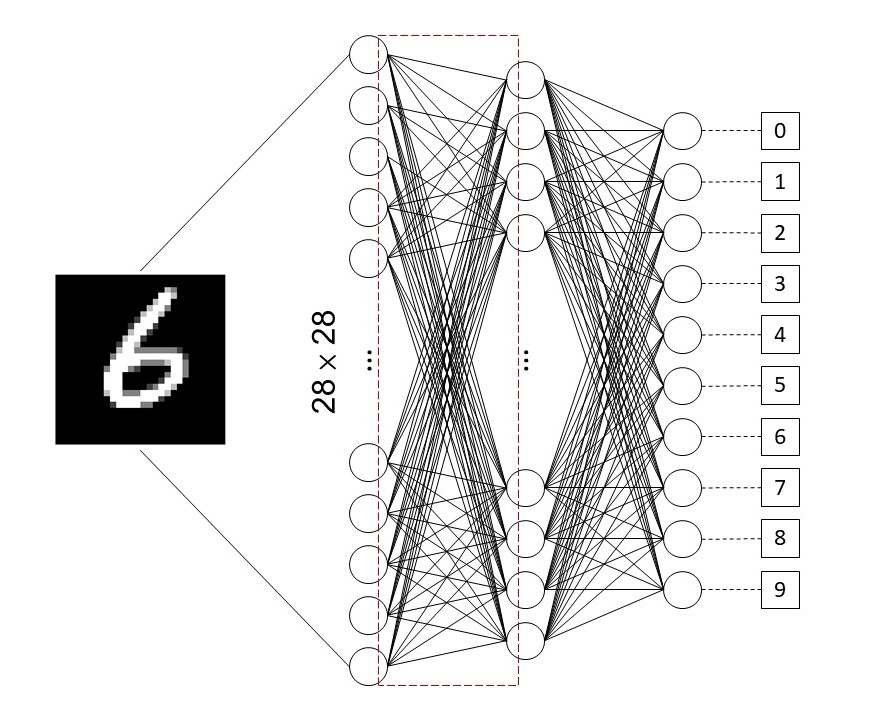

In [1]:
from tensorflow.keras.datasets.mnist import load_data
import numpy as np
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = load_data()

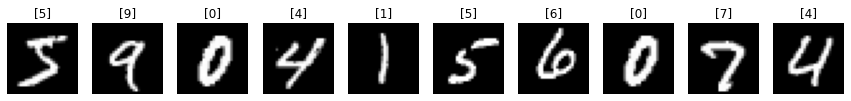

In [2]:
idx = np.random.randint(100, size=10)

plt.figure(figsize=(15,4))
for i, j in enumerate(idx):
  plt.subplot(1,10,i+1)
  plt.title('[{}]'.format(y_train[j]))
  plt.axis('off')
  plt.imshow(x_train[j], 'gray')
plt.show()


(60000, 784) (10000, 784)
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


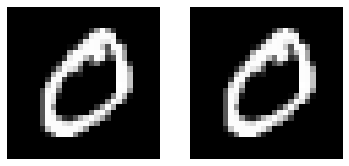

In [3]:
from tensorflow.keras.utils import to_categorical
"""Preprocessing"""
# normaolization
x_train_norm = x_train.reshape(-1, 784) / 255
x_test_norm = x_test.reshape(-1, 784) / 255
print(x_train_norm.shape, x_test_norm.shape)
n_train = x_train_norm.shape[0]
n_test = x_test_norm.shape[0]

# one-hot encoding
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)
print(y_train_cat[1])

# reshape test
test = x_train[1].reshape(-1)
test = test.reshape(28,28)

plt.subplot(1,2,1)
plt.imshow(x_train[1], 'gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(test, 'gray')
plt.axis('off')
plt.show()


In [4]:
"""Build neural network"""
# parameter
wb_width = 0.01
eta = 0.01

# father class
class BaseLayer:
  def __init__(self, n_upper, n):
    self.w = wb_width * np.random.randn(n_upper, n)
    self.b = wb_width * np.random.randn(n)
  
  def update(self, eta):
    self.w -= eta * self.grad_w
    self.b -= eta * self.grad_b

# child class
class MiddleLayer(BaseLayer):
  def forward(self, x):
    self.x = x
    self.u = np.dot(x, self.w) + self.b
    self.y = np.where(self.u < 0, 0.01*self.u, self.u)
  
  def backward(self, grad_y):
    delta = grad_y*np.where(self.u < 0, 0.01, 1)
    self.grad_w = np.dot(self.x.T, delta)
    self.grad_b = np.sum(delta, axis=0)
    self.grad_x = np.dot(delta, self.w.T)

class OutputLayer(BaseLayer):
  def forward(self, x):
    self.x = x
    self.u = np.dot(x, self.w) + self.b
    self.y = np.exp(self.u) / np.sum(np.exp(self.u), axis=1, keepdims=True)
  
  def backward(self, t):
    delta = (self.y - t)
    self.grad_w = np.dot(self.x.T, delta)
    self.grad_b = np.sum(delta, axis=0)
    self.grad_x = np.dot(delta, self.w.T)

# create network
middle_layer = MiddleLayer(784, 30)
output_layer = OutputLayer(30, 10)

# define process
def forward_propagation(x):
  middle_layer.forward(x)
  output_layer.forward(middle_layer.y)

def backpropagation(t):
  output_layer.backward(t)
  middle_layer.backward(output_layer.grad_x)

def update_wb():
  middle_layer.update(eta)
  output_layer.update(eta)

# metric
def get_loss(t, batch_size):
  cross_entropy = t * np.log(output_layer.y+1e-7)
  return -np.sum(cross_entropy) / batch_size

def get_accuracy(answer, predict):
  result = np.argmax(answer, axis=1) == np.argmax(predict, axis=1)
  return np.sum(result)

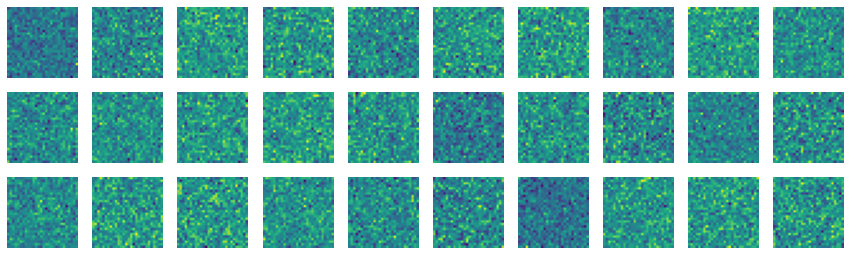

In [5]:
"""Initial weights of each perceptron"""
plt.figure(figsize=(15,6))
total = len(middle_layer.w[0])

for i in range(total):
  plt.subplot(int((total/10)+1),10,i+1)
  plt.axis('off')
  plt.imshow(middle_layer.w[:,i].reshape(28,28))
plt.show()

Epoch:0/100 train_loss:2.302977 test_loss:2.302891
Epoch:10/100 train_loss:0.194991 test_loss:0.218112
Epoch:20/100 train_loss:0.138224 test_loss:0.192543
Epoch:30/100 train_loss:0.112554 test_loss:0.176412
Epoch:40/100 train_loss:0.099831 test_loss:0.181145
Epoch:50/100 train_loss:0.083235 test_loss:0.179463
Epoch:60/100 train_loss:0.074659 test_loss:0.174159
Epoch:70/100 train_loss:0.072086 test_loss:0.181528
Epoch:80/100 train_loss:0.067039 test_loss:0.191313
Epoch:90/100 train_loss:0.057488 test_loss:0.195837


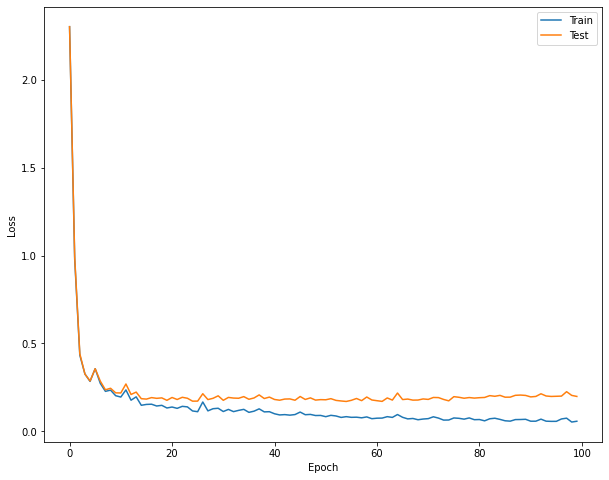

Accuracy Train: 98.3%
 Accuracy Test: 95.6%


In [6]:
"""Training!"""
# parameter
epoch = 100
batch_size = 200
interval = 10

# contains for losses
train_loss_x = []
train_loss_y = []
test_loss_x = []
test_loss_y = []

n_batch = n_train // batch_size

for i in range(epoch):
  # evaluate losses
  forward_propagation(x_train_norm)
  loss_train = get_loss(y_train_cat, n_train)
  forward_propagation(x_test_norm)
  loss_test = get_loss(y_test_cat, n_test)

  train_loss_x.append(i)
  train_loss_y.append(loss_train)
  test_loss_x.append(i)
  test_loss_y.append(loss_test)

  if i%interval == 0:
    print('Epoch:'+str(i)+'/'+str(epoch),
       'train_loss:'+str(round(loss_train,6)),
       'test_loss:'+str(round(loss_test,6)))
  
  # set batch & train
  index_random = np.arange(n_train)
  np.random.shuffle(index_random)

  for j in range(n_batch):
    # set batch
    mb_index = index_random[j*batch_size:(j+1)*batch_size]
    x = x_train_norm[mb_index,:]
    t = y_train_cat[mb_index,:]

    # training 
    forward_propagation(x)
    backpropagation(t)
    update_wb()
  
# plot
plt.figure(figsize=(10,8))
plt.plot(train_loss_x, train_loss_y, label='Train')
plt.plot(test_loss_x, test_loss_y, label='Test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# accuracy
forward_propagation(x_train_norm)
count_train = get_accuracy(y_train_cat, output_layer.y)
forward_propagation(x_test_norm)
count_test = get_accuracy(y_test_cat, output_layer.y)

print('Accuracy Train:', str(round(count_train/n_train*100,1))+'%\n',
   'Accuracy Test:', str(round(count_test/n_test*100,1))+'%')

In [7]:
middle_layer.w.shape

(784, 30)

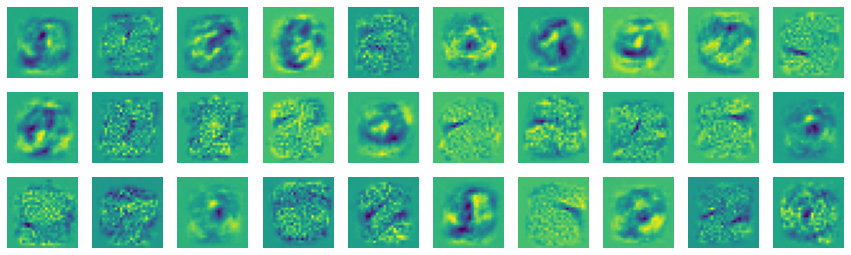

In [8]:
"""Trained weights of each perceptron"""
plt.figure(figsize=(15,6))
total = len(middle_layer.w[0])

for i in range(total):
  plt.subplot(int((total/10)+1),10,i+1)
  plt.axis('off')
  plt.imshow(middle_layer.w[:,i].reshape(28,28))
plt.show()